# Lab3

## 1. Implementing CNN architecture

### LeNet-5

**Download MNIST dataset**

In [1]:
from requests import get

def download_file(url, file_name):
    with open(file_name, "wb") as file:
        response = get(url)
        file.write(response.content)

In [2]:
download_file('http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz', 'train-images-idx3-ubyte.gz')
download_file('http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz', 'train-labels-idx1-ubyte.gz')
download_file('http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz', 't10k-images-idx3-ubyte.gz')
download_file('http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz', 't10k-labels-idx1-ubyte.gz')

**Load the data**

Load train and test data in memory

In [3]:
# Update libraries
!pip install seaborn==0.9.0

In [4]:
import gzip
import numpy as np
import pandas as pd
from time import time

from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
import keras.layers as layers
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.callbacks import TensorBoard

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [5]:
def read_mnist(images_path: str, labels_path: str):
    with gzip.open(labels_path, 'rb') as labelsFile:
        labels = np.frombuffer(labelsFile.read(), dtype=np.uint8, offset=8)

    with gzip.open(images_path,'rb') as imagesFile:
        length = len(labels)
        # Load flat 28x28 px images (784 px), and convert them to 28x28 px
        features = np.frombuffer(imagesFile.read(), dtype=np.uint8, offset=16) \
                        .reshape(length, 784) \
                        .reshape(length, 28, 28, 1)
        
    return features, labels

In [6]:
train = {}
test = {}

train['features'], train['labels'] = read_mnist('train-images-idx3-ubyte.gz', 'train-labels-idx1-ubyte.gz')
test['features'], test['labels'] = read_mnist('t10k-images-idx3-ubyte.gz', 't10k-labels-idx1-ubyte.gz')

#### Display some images

In [7]:
def display_image(position):
    image = train['features'][position].squeeze()
    plt.title('Example %d. Label: %d' % (position, train['labels'][position]))
    plt.imshow(image, cmap=plt.cm.gray_r)

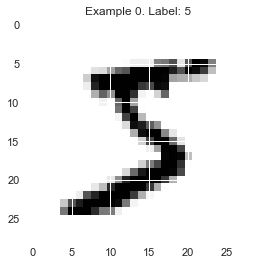

In [8]:
display_image(0)

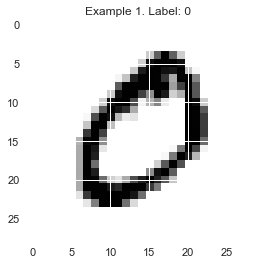

In [9]:
display_image(1)

#### Plot training data

In [10]:
train_labels_count = np.unique(train['labels'], return_counts=True)
dataframe_train_labels = pd.DataFrame({'Label':train_labels_count[0], 'Count':train_labels_count[1]})
dataframe_train_labels

,Label,Count
0,0,5923
1,1,6742
2,2,5958
3,3,6131
4,4,5842
5,5,5421
6,6,5918
7,7,6265
8,8,5851
9,9,5949


### Split training data into training and validation

In [11]:
validation = {}
train['features'], validation['features'], train['labels'], validation['labels'] = train_test_split(train['features'], train['labels'], test_size=0.2, random_state=0)

In [12]:
print('# of training images:', train['features'].shape[0])
print('# of validation images:', validation['features'].shape[0])

# of training images: 48000
# of validation images: 12000


**Prepare our input features**

The LeNet architecture accepts a 32x32 pixel images as input, mnist data is 28x28 pixels. <br>
We simply pad the images with zeros to overcome that.

In [13]:
# Pad images with 0s
train['features']      = np.pad(train['features'], ((0,0),(2,2),(2,2),(0,0)), 'constant')
validation['features'] = np.pad(validation['features'], ((0,0),(2,2),(2,2),(0,0)), 'constant')
test['features']       = np.pad(test['features'], ((0,0),(2,2),(2,2),(0,0)), 'constant')
    
print("Updated Image Shape: {}".format(train['features'][0].shape))

Updated Image Shape: (32, 32, 1)


## LeNet-5 implmentation


#### Input
    32x32x1 pixels image

#### Architecture
* **Convolutional #1** outputs 28x28x6
    * **Activation** any activation function, we will `relu`

* **Pooling #1** The output shape should be 14x14x6.

* **Convolutional #2** outputs 10x10x16.
    * **Activation** any activation function, we will `relu`

* **Pooling #2** outputs 5x5x16.
    * **Flatten** Flatten the output shape of the final pooling layer

* **Fully Connected #1** outputs 120
    * **Activation** any activation function, we will `relu`

* **Fully Connected #2** outputs 84
    * **Activation** any activation function, we will `relu`

* **Fully Connected (Logits) #3** outpute 10


In [14]:
model = keras.Sequential()

model.add(layers.Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=(32,32,1)))
model.add(layers.AveragePooling2D())

model.add(layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
model.add(layers.AveragePooling2D())

model.add(layers.Flatten())

model.add(layers.Dense(units=120, activation='relu'))

model.add(layers.Dense(units=84, activation='relu'))

model.add(layers.Dense(units=10, activation = 'softmax'))

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 6)         60        
                                                                 
 average_pooling2d (AverageP  (None, 15, 15, 6)        0         
 ooling2D)                                                       
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 16)        880       
                                                                 
 average_pooling2d_1 (Averag  (None, 6, 6, 16)         0         
 ePooling2D)                                                     
                                                                 
 flatten (Flatten)           (None, 576)               0         
                                                                 
 dense (Dense)               (None, 120)               6

In [16]:
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

In [17]:
EPOCHS = 5
BATCH_SIZE = 128

In [18]:
X_train, y_train = train['features'], to_categorical(train['labels'])
X_validation, y_validation = validation['features'], to_categorical(validation['labels'])

train_generator = ImageDataGenerator().flow(X_train, y_train, batch_size=BATCH_SIZE)
validation_generator = ImageDataGenerator().flow(X_validation, y_validation, batch_size=BATCH_SIZE)

In [19]:
print('# of training images:', train['features'].shape[0])
print('# of validation images:', validation['features'].shape[0])

steps_per_epoch = X_train.shape[0]//BATCH_SIZE
validation_steps = X_validation.shape[0]//BATCH_SIZE

tensorboard = TensorBoard(log_dir="logs/{}".format(time()))
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=EPOCHS, 
                    validation_data=validation_generator, validation_steps=validation_steps, 
                    shuffle=True, callbacks=[tensorboard])

# of training images: 48000
# of validation images: 12000


<ipython-input-19-6bebf831c239>:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=EPOCHS,


Epoch 1/5
375/375 [==============================] - 16s 38ms/step - loss: 0.5664 - accuracy: 0.9066 - val_loss: 0.1210 - val_accuracy: 0.9643
Epoch 2/5
375/375 [==============================] - 12s 33ms/step - loss: 0.0964 - accuracy: 0.9710 - val_loss: 0.0766 - val_accuracy: 0.9773
Epoch 3/5
375/375 [==============================] - 13s 35ms/step - loss: 0.0629 - accuracy: 0.9810 - val_loss: 0.0576 - val_accuracy: 0.9819
Epoch 4/5
375/375 [==============================] - 12s 32ms/step - loss: 0.0459 - accuracy: 0.9852 - val_loss: 0.0530 - val_accuracy: 0.9829
Epoch 5/5
375/375 [==============================] - 13s 35ms/step - loss: 0.0377 - accuracy: 0.9880 - val_loss: 0.0511 - val_accuracy: 0.9843


In [20]:
score = model.evaluate(test['features'], to_categorical(test['labels']))
print('Test loss:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 2s 6ms/step - loss: 0.0448 - accuracy: 0.9861
Test loss: 0.04481274262070656
Test accuracy: 0.9861000180244446


### VGG-16

In [21]:
def Snippet_366(): 

    print()
    print(format('How to classify digits using a VGG16 network achitecture in Keras and Python ','*^102'))

    import time
    start_time = time.time()

    from keras.datasets import mnist
    from keras.utils import np_utils
    from keras.models import Sequential
    from keras.layers.core import Dense, Dropout, Flatten
    from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
    from tensorflow.keras.optimizers import RMSprop
    import matplotlib.pyplot as plt

    # MNIST is a set of 70K images 28x28 pixels 
    IMG_CHANNELS = 1; IMG_ROWS = 28; IMG_COLS = 28;

    #constant
    BATCH_SIZE = 128; NB_EPOCH = 2; NB_CLASSES = 10; VERBOSE = 1; VALIDATION_SPLIT = 0.2;

    #load dataset
    (X_train, y_train), (X_test, y_test) = mnist.load_data()

    print('X_train shape:', X_train.shape)
    print(X_train.shape[0], 'train samples')
    print(X_test.shape[0], 'test samples')

    # Reshape Input
    X_train = X_train.reshape(X_train.shape[0], IMG_ROWS, IMG_COLS, IMG_CHANNELS)
    X_test  = X_test.reshape(X_test.shape[0], IMG_ROWS, IMG_COLS, IMG_CHANNELS)    

    # convert to categorical
    Y_train = np_utils.to_categorical(y_train, NB_CLASSES)
    Y_test = np_utils.to_categorical(y_test, NB_CLASSES) 

    # float and normalization
    X_train = X_train.astype('float32'); X_test = X_test.astype('float32');
    X_train /= 255; X_test /= 255;

    # --------------------------------------
    # VGG16 network Architecture in Keras
    # --------------------------------------    
    model = Sequential()
    
    model.add(ZeroPadding2D((1,1), input_shape=(IMG_ROWS, IMG_COLS, IMG_CHANNELS)))
    model.add(Conv2D(filters = 64, kernel_size = 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(filters = 64, kernel_size = 3, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(filters = 128, kernel_size = 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(filters = 128, kernel_size = 3, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(filters = 256, kernel_size = 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(filters = 256, kernel_size = 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(filters = 256, kernel_size = 3, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(filters = 512, kernel_size = 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(filters = 512, kernel_size = 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(filters = 512, kernel_size = 3, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(filters = 1024, kernel_size = 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(filters = 1024, kernel_size = 3, activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Conv2D(filters = 1024, kernel_size = 3, activation='relu'))
    model.add(MaxPooling2D(pool_size=(1,1), strides=(1,1)))

    model.add(Flatten())

    #top layer of the VGG net
    model.add(Dense(units = 4096, activation='relu')); model.add(Dropout(0.5))
    model.add(Dense(units = 4096, activation='relu')); model.add(Dropout(0.5))
    model.add(Dense(NB_CLASSES, activation='softmax'))
    model.summary()

    # train
    model.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])

    history = model.fit(X_train, Y_train, batch_size=BATCH_SIZE,
           epochs=NB_EPOCH, validation_split=VALIDATION_SPLIT, verbose=VERBOSE)

    print('Testing...')
    score = model.evaluate(X_test, Y_test, batch_size=BATCH_SIZE, verbose=VERBOSE)
    print("\nTest score:", score[0]); print('Test accuracy:', score[1]);

    # save model
    model_json = model.to_json()
    open('cifar10_architecture_VGG16.json', 'w').write(model_json)
    model.save_weights('cifar10_weights_VGG16.h5', overwrite=True)

    # list all data in history
    print(history.history.keys()); print(history.history)

    # summarize history for accuracy
    plt.plot(history.history['accuracy']); plt.plot(history.history['val_accuracy']);
    plt.title('model accuracy'); plt.ylabel('accuracy'); plt.xlabel('epoch'); 
    plt.legend(['train', 'test'], loc='upper left'); plt.show()

    # summarize history for loss
    plt.plot(history.history['loss']); plt.plot(history.history['val_loss']);
    plt.title('model loss'); plt.ylabel('loss'); plt.xlabel('epoch');
    plt.legend(['train', 'test'], loc='upper left'); plt.show()

    print(); print("Execution Time %s seconds: " % (time.time() - start_time))

Snippet_366()


************How to classify digits using a VGG16 network achitecture in Keras and Python *************
X_train shape: (60000, 28, 28)
60000 train samples
10000 test samples
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 zero_padding2d (ZeroPadding  (None, 30, 30, 1)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        640       
                                                                 
 zero_padding2d_1 (ZeroPaddi  (None, 30, 30, 64)       0         
 ng2D)                                                           
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 64)        36928     
                                                                 
 max_pooling

KeyboardInterrupt: 

# 2. Fine-tuning a pretrained model

## VGG-16

In [22]:
# importing libraries

import numpy as np
import matplotlib.pyplot as plt
import os
import random
from tqdm import tqdm # for progress bar

# Libraries for TensorFlow
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras import models, layers
from tensorflow import keras

# Library for Transfer Learning
from tensorflow.keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input

print("Importing libraries completed.")

Importing libraries completed.


**Loading dataset from keras**

In [23]:
(xtrain,ytrain),(xtest,ytest)= keras.datasets.mnist.load_data()

**Verifying dataset**

In [24]:
print(xtrain.shape)
print(ytrain.shape)
print(xtest.shape)
print(ytest.shape)
print(ytrain)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)
[5 0 4 ... 5 6 8]


**Convert the images into 3 channels as MNIST images are Black and White so have 1 channel and Reshape images as per the tensor format required by tensorflow **

In [25]:
xtrain=np.dstack([xtrain] * 3)
xtest=np.dstack([xtest]*3)
xtrain.shape,xtest.shape
xtrain = xtrain.reshape(-1, 28,28,3)
xtest= xtest.reshape (-1,28,28,3)
xtrain.shape,xtest.shape

((60000, 28, 28, 3), (10000, 28, 28, 3))

**Resize the images 48*48 as required by VGG16**

In [26]:
from keras.preprocessing.image import img_to_array, array_to_img

xtrain = np.asarray([img_to_array(array_to_img(im, scale=False).resize((48,48))) for im in xtrain])
xtest = np.asarray([img_to_array(array_to_img(im, scale=False).resize((48,48))) for im in xtest])
#train_x = preprocess_input(x)
xtrain.shape, xtest.shape

((60000, 48, 48, 3), (10000, 48, 48, 3))

In [27]:
# # listing the folders containing images

# preparing array that can be used later

class_names=['Zero', 'One', 'Two', 'Three', 'Four', 'Five', 'Six', 'Seven', 'Eight', 'Nine']
print(class_names)

val_class_names =['Zero', 'One', 'Two', 'Three', 'Four', 'Five', 'Six', 'Seven', 'Eight', 'Nine']
print(val_class_names)

test_class_names=['Zero', 'One', 'Two', 'Three', 'Four', 'Five', 'Six', 'Seven', 'Eight', 'Nine']
print(test_class_names)

# Function to know the name of the element

def Get_Element_Name(argument):
    switcher = {
        0: "Zero",
        1: "One",
        2: "Two",
        3: "Three",
        4: "Four",
        5: "Five",
        6: "Six",
        7: "Seven",
        8: "Eight",
        9: "Nine",
    }
    return switcher.get(argument, "Invalid")

print(Get_Element_Name(0))

['Zero', 'One', 'Two', 'Three', 'Four', 'Five', 'Six', 'Seven', 'Eight', 'Nine']
['Zero', 'One', 'Two', 'Three', 'Four', 'Five', 'Six', 'Seven', 'Eight', 'Nine']
['Zero', 'One', 'Two', 'Three', 'Four', 'Five', 'Six', 'Seven', 'Eight', 'Nine']
Zero


In [39]:
# Preparing data

x=[] # to store array value of the images
x=xtrain
y=[] # to store the labels of the images
y=ytrain

test_images=[]
test_images=xtest
test_images_Original=[]
test_images_Original=xtest
test_image_label=[] # to store the labels of the images
test_image_label=ytest

val_images=[]
val_images=xtest
val_images_Original=[]
val_images_Original=xtest
val_image_label=[] # to store the labels of the images
val_image_label=ytest # to store the labels of the images

print("Preparing Dataset Completed.")

# Training Dataset
print("Training Dataset")

x=np.array(x) # Converting to np arrary to pass to the model
print(x.shape)

y=to_categorical(y) # onehot encoding of the labels
# print(y)
print(y.shape)

# Test Dataset
print("Test Dataset")

test_images=np.array(test_images) 
print(test_images.shape)

test_image_label=to_categorical(test_image_label) # onehot encoding of the labels)
print(test_image_label.shape)

# Validation Dataset
print("Validation Dataset")

val_images=np.array(val_images) 
print(val_images.shape)

val_image_label=to_categorical(val_image_label) # onehot encoding of the labels)
print(val_image_label.shape)

Preparing Dataset Completed.
Training Dataset
(48000, 48, 48, 3)
(48000, 10)
Test Dataset
(12000, 48, 48, 3)
(12000, 10)
Validation Dataset
(12000, 48, 48, 3)
(12000, 10)


**VGG-16 implmentation**

In [40]:
#Check properties of the model that we are going to use for Transfer Learning
print("Summary of default VGG16 model.\n")

# we are using VGG16 for transfer learnin here. So we have imported it
from tensorflow.keras.applications import VGG16

# initializing model with weights='imagenet'i.e. we are carring its original weights
model_vgg16=VGG16(weights='imagenet')

# display the summary to see the properties of the model
model_vgg16.summary()

Summary of default VGG16 model.

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D) 

In [41]:

# Here we will prepare model as per our requirements

print("Summary of Custom VGG16 model.\n")
print("1) We setup input layer and 2) We removed top (last) layer. \n")

# let us prepare our input_layer to pass our image size. default is (224,224,3). we will change it to (224,224,3)
input_layer=layers.Input(shape=(48,48,3))

# initialize the transfer model VGG16 with appropriate properties per our need.

model_vgg16=VGG16(weights='imagenet',input_tensor=input_layer,include_top=False)

# See the summary of the model with our properties.
model_vgg16.summary()

Summary of Custom VGG16 model.

1) We setup input layer and 2) We removed top (last) layer. 

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                 

In [42]:
# access the current last layer of the model and add flatten and dense after it

print("Summary of Custom VGG16 model.\n")
print("1) We flatten the last layer and added 1 Dense layer and 1 output layer.\n")

last_layer=model_vgg16.output # we are taking last layer of the model

# Add flatten layer: we are extending Neural Network by adding flattn layer
flatten=layers.Flatten()(last_layer) 

# Add dense layer
dense1=layers.Dense(100,activation='relu')(flatten)
dense1=layers.Dense(100,activation='relu')(flatten)
dense1=layers.Dense(100,activation='relu')(flatten)


# Add dense layer to the final output layer
output_layer=layers.Dense(10,activation='softmax')(flatten)

# Creating modle with input and output layer
model=models.Model(inputs=input_layer,outputs=output_layer)

# Summarize the model
model.summary()

Summary of Custom VGG16 model.

1) We flatten the last layer and added 1 Dense layer and 1 output layer.

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                   

In [43]:
# freez all the layers except the last layer

#all the layers intrainable except the last layer
print("We are making all the layers intrainable except the last layer. \n")
for layer in model.layers[:-1]:
    layer.trainable=False
model.summary()

We are making all the layers intrainable except the last layer. 

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                           

In [44]:
# Train the Model

from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(x,y,test_size=0.2,random_state=5)
# print(xtrain)
# print(xtest)
# print(ytrain)
# print(ytest)

print("Splitting data for train and test completed.")

Splitting data for train and test completed.


In [45]:
# Compiling Model

model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

print("Model compilation completed.")
model.summary()

Model compilation completed.
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (

In [46]:
# Fit the Model

# xtrain2=xtrain.reshape(60000,48,48,3)
# xtest2=xtest.reshape(10000,48,48,3)

history = model.fit(xtrain,ytrain,epochs=5,batch_size=128,verbose=True,validation_data=(xtest,ytest))

print("Fitting the model completed.")

Epoch 1/5
300/300 [==============================] - 329s 1s/step - loss: 2.7562 - accuracy: 0.6667 - val_loss: 0.7293 - val_accuracy: 0.8335
Epoch 2/5
300/300 [==============================] - 325s 1s/step - loss: 0.5509 - accuracy: 0.8659 - val_loss: 0.4680 - val_accuracy: 0.8770
Epoch 3/5
300/300 [==============================] - 317s 1s/step - loss: 0.3884 - accuracy: 0.8948 - val_loss: 0.3890 - val_accuracy: 0.8918
Epoch 4/5
300/300 [==============================] - 317s 1s/step - loss: 0.3162 - accuracy: 0.9099 - val_loss: 0.3318 - val_accuracy: 0.9046
Epoch 5/5
300/300 [==============================] - 319s 1s/step - loss: 0.2788 - accuracy: 0.9184 - val_loss: 0.3028 - val_accuracy: 0.9122
Fitting the model completed.


In [47]:
#predict individual image supplied to it

def predict(img_name):
    img=image.load_img(img_name,target_size=(48,48))
    img=image.img_to_array(img)
    plt.imshow(img.astype('int32'))
    plt.show()
    img=preprocess_input(img)

    prediction=model.predict(img.reshape(1,48,48,3))
    output=np.argmax(prediction)

    print(class_names[output] + ": " + Get_Element_Name(class_names[output]))



# This function plots the image supplied in array
def plot_image(i, predictions_array, true_label, img): # taking index and 3 arrays viz. prediction array, true label array and image array
    
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    plt.imshow(img.astype('int32'))
    
    predicted_label=np.argmax(predictions_array)
    true_label=np.argmax(true_label)

    if predicted_label == true_label: #setting up label color
        color='green' # correct then blue colour
    else:
        color='red' # wrong then red colour
    
    plt.xlabel("{} {:2.0f}% \n ({})".format(Get_Element_Name(predicted_label), 
                                            100*np.max(predictions_array), Get_Element_Name(true_label), 
                                            color=color, horizontalalignment='left'))

# This function plots bar chart supplied in the array data
def plot_value_array(i, predictions_array, true_label): # taking index along with predictions and true label array
    predictions_array, true_label = predictions_array[i], true_label[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    predicted_label=np.argmax(predictions_array)
    true_label=np.argmax(true_label)

    if predicted_label == 0:
        predicted_label=1
    if true_label == 0:
        true_label=1
    
    thisplot=plt.bar(range(10), predicted_label, color='seashell')
    plt.ylim([0,1])

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('green')

In [48]:
# Preparing prediction arrary
predictions=[]

for img in tqdm(val_images):
    img=img.reshape(1,48,48,3)
    predictions.append(model.predict(img))

100%|██████████| 12000/12000 [16:29<00:00, 12.13it/s] 


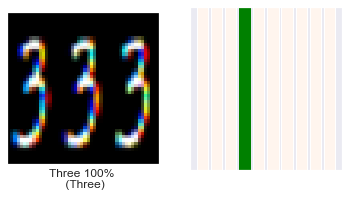

In [51]:
# Prediction of individual images taken from internet

i=random.randrange(1, 10000)
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)

plot_image(i,predictions, val_image_label, val_images_Original) 
plt.subplot(1,2,2)
plot_value_array(i, predictions, val_image_label)
plt.show()

Classification of using Transfer Learning (VGG16)

Predicted, Percentage, (Original)



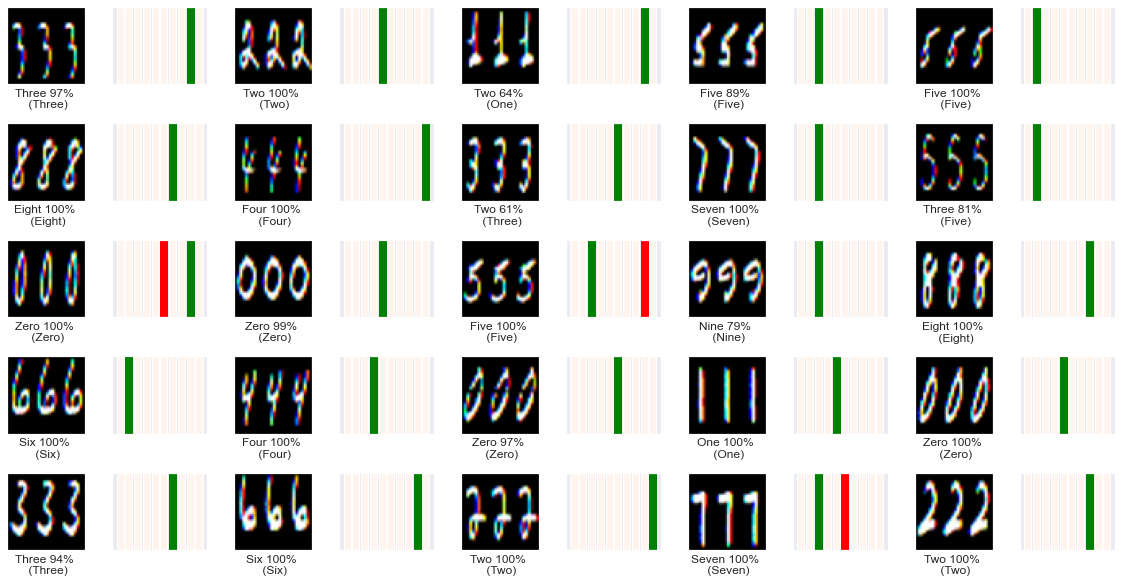

In [52]:
# Declaring variables
num_rows=5
num_cols=5
num_images=num_rows*num_cols

plt.figure(figsize=(2*2*num_cols,2*num_rows))

print("Classification of using Transfer Learning (VGG16)\n")
print("Predicted, Percentage, (Original)\n")

for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    ii=random.randrange(1,10000)
 
    plot_image(ii,predictions, val_image_label, val_images_Original)
    
    plt.subplot(num_rows, 2*num_cols, 2*i+2)

    plot_value_array(i, predictions, val_image_label)
plt.subplots_adjust(hspace=0.5)
plt.show()

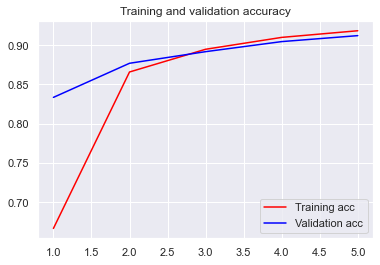

<Figure size 432x288 with 0 Axes>

In [54]:
# plot the loss and accuracy

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()

plt.show()

# 3. CNN vs FC

CNNs are trained to identify and extract the best features from the images for the problem at 
hand. That is their main strength. The latter layers of a CNN are fully connected because of their strength as a classifier.
<br>
Although fully connected networks make no assumptions about the input they tend to perform less and aren’t good for feature extraction. Plus they have a higher number of weights to train that results in high training time while on the other hand CNNs are trained to identify and extract the best features from the images for the problem at hand with relatively fewer parameters to train.
<br>
As we are trying to classify digits and as we have seen CNN provides more accuracy than FC